# Introduction 

Ce projet concerne le Travail de Bachelor sur l'analyse de données en temps réel sur l'arbitrage du light-contact boxing. Le but est de signaler en temps réel les divergences de points attribués par les juges.


## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats as stats
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

## Data exploration
Chargement du fichier CSV LCBA_scores.csv

Voici une visualisation du match_id 21096

In [2]:
data = pd.read_csv('LCBA_scores.csv')

cols_to_display = ['score_id', 'red_point','red_penalty', 'blue_point','blue_penalty', 'date_create_app', 'judge_id', 'match_id']
data[cols_to_display]

,score_id,red_point,red_penalty,blue_point,blue_penalty,date_create_app,judge_id,match_id
0,1,0,0,0,0,NaN,114816,21089
1,2,0,0,0,0,NaN,114822,21089
2,3,0,0,0,0,NaN,114824,21089
3,4,0,0,0,0,NaN,114826,21093
4,5,0,0,0,0,NaN,114813,21093
...,...,...,...,...,...,...,...,...
38778,38952,1,0,0,0,2023-04-15 14:18:52.2+00,115226,22514
38779,38953,1,0,0,0,2023-04-15 14:18:51.485+00,114927,22514
38780,38954,1,0,0,0,2023-04-15 14:18:56.33+00,114927,22514
38781,38955,1,0,0,0,2023-04-15 14:18:56.889+00,114926,22514


Colonne red_point

In [3]:
data.red_point.describe()

count    38783.000000
mean         0.456102
std          0.561632
min         -3.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: red_point, dtype: float64

Colonne blue_point

In [4]:
data.blue_point.describe()

count    38783.000000
mean         0.457288
std          0.556790
min         -3.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: blue_point, dtype: float64

Colonne date_create_app

In [5]:
data.date_create_app.describe()

count                          36786
unique                         36782
top       2022-06-18 12:36:59.029+00
freq                               2
Name: date_create_app, dtype: object

On voit qu'il existe des valeurs null et négatives, quelques modifications/correction sonz apporter.
Nous allons prémièrement se concentrer sur un seul match_id.

In [6]:
negative_scores = data[(data['red_point'] < 0) | (data['blue_point'] < 0)].sort_values('score_id')

cols_to_display2 = ['score_id', 'red_point', 'blue_point', 'judge_id']
negative_scores.loc[negative_scores['match_id'] == 21096, cols_to_display2]

,score_id,red_point,blue_point,judge_id
393,394,0,-1,114819
427,428,-1,0,114819
428,429,-1,0,114819
444,445,-1,0,114813


Et maintenant s'il existe valeurs supérieur à 1.

In [7]:
negative_scores = data[(data['red_point'] > 1) | (data['blue_point'] > 1)].sort_values('score_id')

cols_to_display2 = ['score_id', 'red_point', 'blue_point', 'judge_id']
negative_scores.loc[negative_scores['match_id'] == 21096, cols_to_display2]

,score_id,red_point,blue_point,judge_id


Ces valeurs devront être traitées.
Nous allons maintenant voir la forme (type) de nos données :

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38783 entries, 0 to 38782
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   score_id                  38783 non-null  int64  
 1   red_penalty               38783 non-null  int64  
 2   red_point                 38783 non-null  int64  
 3   blue_penalty              38783 non-null  int64  
 4   blue_point                38783 non-null  int64  
 5   date_create               38783 non-null  object 
 6   date_change               38783 non-null  object 
 7   judge_id                  38783 non-null  int64  
 8   match_id                  38783 non-null  int64  
 9   date_create_app           36786 non-null  object 
 10  uuid                      36786 non-null  object 
 11  judge_club_id             38783 non-null  int64  
 12  match_id.1                38783 non-null  int64  
 13  PalmaresDate              38783 non-null  object 
 14  winner

## Data preparation

### Conversion date
On constate qu'il considère les format de date comme des objets. On les convertit pour pour faciliter les prochains calculs sur la série temporelle. Le datetime64[ns] est un type de données utilisé dans Pandas pour représenter les dates et heures avec une précision jusqu'à la nanoseconde. 

In [9]:
cols_to_convert = ['date_create', 'date_change','date_create_app','PalmaresDate','PalmaresRealEndTime','PalmaresRealStartTime','open_time']
data[cols_to_convert] = data[cols_to_convert].apply(pd.to_datetime)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38783 entries, 0 to 38782
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   score_id                  38783 non-null  int64              
 1   red_penalty               38783 non-null  int64              
 2   red_point                 38783 non-null  int64              
 3   blue_penalty              38783 non-null  int64              
 4   blue_point                38783 non-null  int64              
 5   date_create               38783 non-null  datetime64[ns, UTC]
 6   date_change               38783 non-null  datetime64[ns, UTC]
 7   judge_id                  38783 non-null  int64              
 8   match_id                  38783 non-null  int64              
 9   date_create_app           36786 non-null  datetime64[ns, UTC]
 10  uuid                      36786 non-null  object             
 11  judge_club_id  

### Suppresion des colonnes null

In [11]:
null_rows = negative_scores[negative_scores['date_create_app'].isnull()]

cols_to_display2 = ['score_id', 'red_point', 'blue_point', 'judge_id', 'date_create_app']
print(null_rows[cols_to_display2])

# Supprimer les lignes
data = data.dropna(subset=['date_create_app'])

Empty DataFrame
Columns: [score_id, red_point, blue_point, judge_id, date_create_app]
Index: []


### Suppresssion des lignes négatives

Nous avons constaté précédement qu'il y avait des lignes négatives. Il ne faut pas les considérer. Une ligne négative est créée pour un éventuel réquilibrage si le juge attribue un point par erreur.

In [12]:
match_21096 = data.loc[data['match_id'] == 21096].sort_values('score_id')

cols_to_display = ['score_id', 'red_point', 'red_penalty', 'blue_point', 'blue_penalty', 'date_create_app', 'judge_id', 'match_id']
match_21096_filtered = match_21096.loc[:, cols_to_display]

print("Données pour le match_id 21096 :")
print(match_21096_filtered)

Données pour le match_id 21096 :
     score_id  red_point  red_penalty  blue_point  blue_penalty  \
392       393          0            0           1             0   
393       394          0            0          -1             0   
400       401          0            0           1             0   
401       402          1            0           0             0   
402       403          1            0           0             0   
..        ...        ...          ...         ...           ...   
478       479          1            0           0             0   
479       480          1            0           0             0   
480       481          0            0           1             0   
481       482          0            0           1             0   
482       483          1            0           0             0   

                     date_create_app  judge_id  match_id  
392 2021-06-26 11:43:43.749000+00:00    114819     21096  
393 2021-06-26 11:43:45.252000+00:00    1148

In [13]:
negative_scores = data[(data['red_point'] < 0) | (data['blue_point'] < 0)].sort_values('score_id')

cols_to_display2 = ['score_id', 'red_point', 'blue_point', 'judge_id']
negative_scores.loc[negative_scores['match_id'] == 21096, cols_to_display2]

,score_id,red_point,blue_point,judge_id
393,394,0,-1,114819
427,428,-1,0,114819
428,429,-1,0,114819
444,445,-1,0,114813


Nous allons donc cherche donc chercher 
- la ligne précèdente 
- la ligne suivante 
- la différence de temps avec la ligne précèdente
- la différence de temps avec la ligne suivante
- la ligne identifiante (score_id) qui est la plus proche

In [14]:
data = data[data['match_id'] == 21096]

# Création d'un dictionnaire contenant les scores positifs de chaque juge pour chaque match
positive_scores_dict = {}
positive_scores = data[(data['red_point'] > 0) | (data['blue_point'] > 0)]
for _, row in positive_scores.iterrows():
    judge_id = row['judge_id']
    match_id = row['match_id']
    if match_id not in positive_scores_dict:
        positive_scores_dict[match_id] = {}
    if judge_id not in positive_scores_dict[match_id]:
        positive_scores_dict[match_id][judge_id] = []
    positive_scores_dict[match_id][judge_id].append(row)

# Parcourir les lignes avec des scores négatifs
for _, row in negative_scores.iterrows():
    score_id = row['score_id']
    judge_id = row['judge_id']
    match_id = row['match_id']

    # Trouver les deux scores positifs les plus proches en termes de date_create_app avec le même judge_id
    closest_scores = []
    if match_id in positive_scores_dict and judge_id in positive_scores_dict[match_id]:
        for positive_row in positive_scores_dict[match_id][judge_id]:
            time_diff = abs(row['date_create_app'] - positive_row['date_create_app'])
            closest_scores.append((time_diff, positive_row))
        closest_scores.sort(key=lambda x: x[0])

    # Récupération des informations des scores positifs les plus proches
    if closest_scores:
        closest_row1 = closest_scores[0][1]
        if len(closest_scores) > 1:
            closest_row2 = closest_scores[1][1]
        else:
            closest_row2 = None
    else:
        closest_row1 = None
        closest_row2 = None

    # Ajout des informations dans les colonnes correspondantes
    negative_scores.at[row.name, 'closest_score1'] = closest_row1['score_id'] if closest_row1 is not None else None
    negative_scores.at[row.name, 'closest_score2'] = closest_row2['score_id'] if closest_row2 is not None else None
    negative_scores.at[row.name, 'time_diff1'] = closest_scores[0][0].total_seconds() if closest_row1 is not None else None
    negative_scores.at[row.name, 'time_diff2'] = closest_scores[1][0].total_seconds() if closest_row2 is not None else None

    # Ajout d'une colonne pour le score_id correspondant au temps le plus court
    if closest_scores:
        closest_score_id = closest_scores[0][1]['score_id']
        negative_scores.at[row.name, 'closest_score_id'] = closest_score_id
    else:
        negative_scores.at[row.name, 'closest_score_id'] = None


# Affichage des colonnes spécifiées pour les données avec match_id 21096
cols_to_display4 = ['score_id', 'red_point', 'blue_point', 'judge_id', 'closest_score1', 'closest_score2', 'time_diff1', 'time_diff2', 'closest_score_id']
negative_scores.loc[negative_scores['match_id'] == 21096, cols_to_display4]


,score_id,red_point,blue_point,judge_id,closest_score1,closest_score2,time_diff1,time_diff2,closest_score_id
393,394,0,-1,114819,393.0,404.0,1.503,51.924,393.0
427,428,-1,0,114819,430.0,423.0,3.765,12.132,430.0
428,429,-1,0,114819,430.0,423.0,1.689,14.208,430.0
444,445,-1,0,114813,443.0,446.0,2.349,3.259,443.0


In [15]:
average_min_time_diff = negative_scores[['time_diff1', 'time_diff2']].min(axis=1).mean()

print("Moyenne des plus petites valeurs entre time_diff1 et time_diff2 :")
print(average_min_time_diff)

Moyenne des plus petites valeurs entre time_diff1 et time_diff2 :
2.3265000000000002


In [16]:
data = data[data['match_id'] == 21096]

# Création d'un dictionnaire contenant les scores positifs de chaque juge pour chaque match
positive_scores_dict = {}
positive_scores = data[(data['red_point'] > 0) | (data['blue_point'] > 0)]
for _, row in positive_scores.iterrows():
    judge_id = row['judge_id']
    match_id = row['match_id']
    if match_id not in positive_scores_dict:
        positive_scores_dict[match_id] = {}
    if judge_id not in positive_scores_dict[match_id]:
        positive_scores_dict[match_id][judge_id] = []
    positive_scores_dict[match_id][judge_id].append(row)

# Obtention des score_id et closest_score_id à partir de cols_to_display4
score_ids = negative_scores.loc[negative_scores['match_id'] == 21096, 'score_id'].tolist()
closest_score_ids = negative_scores.loc[negative_scores['match_id'] == 21096, 'closest_score_id'].tolist()

# Filtre des lignes de données selon les score_id et closest_score_id
filtered_data = data[data['score_id'].isin(score_ids) | data['score_id'].isin(closest_score_ids)]

# Sélection des colonnes spécifiées dans cols_to_display5
cols_to_display5 = ['score_id', 'red_point', 'blue_point', 'judge_id']
filtered_data.loc[filtered_data['match_id'] == 21096, cols_to_display5]

# Suppression des lignes de data correspondant à filtered_data
data = data.drop(filtered_data.index)

# Affichage des lignes supprimées
cols_to_display5 = ['score_id', 'red_point', 'blue_point', 'judge_id']
filtered_data.loc[filtered_data['match_id'] == 21096, cols_to_display5]

,score_id,red_point,blue_point,judge_id
392,393,0,1,114819
393,394,0,-1,114819
427,428,-1,0,114819
428,429,-1,0,114819
429,430,0,1,114819
442,443,1,0,114813
444,445,-1,0,114813


Nous connaissons maintenant les lignes portant des valeurs négatives et sur quelle ligne elle a été compensée. Ce nettoyage permettra une meilleure précision lors de la détection des moments d'échanges.

In [17]:
match = data.loc[data['match_id'] == 21096, cols_to_display]
num_rows = len(match.index)
print("Nombre de lignes existantes :", num_rows)

Nombre de lignes existantes : 68


In [18]:
index_to_drop = data[(data['match_id'] == 21096) & ((data['red_point'] < 0) | (data['blue_point'] < 0))].index
data.drop(index=index_to_drop, inplace=True)

In [19]:
match = data.loc[data['match_id'] == 21096, cols_to_display]
num_rows = len(match.index)
print("Nombre de lignes existantes :", num_rows)

Nombre de lignes existantes : 68


In [20]:
# Afficher les colonnes spécifiées pour les données avec match_id 21096
cols_to_display = ['score_id', 'red_point', 'red_penalty', 'blue_point', 'blue_penalty', 'date_create_app', 'judge_id', 'match_id']
data.loc[data['match_id'] == 21096, cols_to_display]

,score_id,red_point,red_penalty,blue_point,blue_penalty,date_create_app,judge_id,match_id
400,401,0,0,1,0,2021-06-26 11:44:32.023000+00:00,114813,21096
401,402,1,0,0,0,2021-06-26 11:44:33.222000+00:00,114826,21096
402,403,1,0,0,0,2021-06-26 11:44:36.483000+00:00,114813,21096
403,404,1,0,0,0,2021-06-26 11:44:37.176000+00:00,114819,21096
404,405,0,0,1,0,2021-06-26 11:44:38.860000+00:00,114819,21096
...,...,...,...,...,...,...,...,...
478,479,1,0,0,0,2021-06-26 11:49:13.858000+00:00,114819,21096
479,480,1,0,0,0,2021-06-26 11:49:14.303000+00:00,114813,21096
480,481,0,0,1,0,2021-06-26 11:49:16.728000+00:00,114813,21096
481,482,0,0,1,0,2021-06-26 11:49:18.399000+00:00,114826,21096


## Modelling
### Graphes

In [21]:
total_points = data.groupby("match_id")[["red_point", "blue_point"]].sum().reset_index()

print(total_points)

   match_id  red_point  blue_point
0     21096         35          33


In [22]:
match_rows = data.loc[data['match_id'] == 21096]

scores_by_judge = match_rows.groupby(['match_id', 'judge_id']).sum()[['red_point', 'blue_point']]

print(scores_by_judge)

                   red_point  blue_point
match_id judge_id                       
21096    114813           13          16
         114819           11          10
         114826           11           7


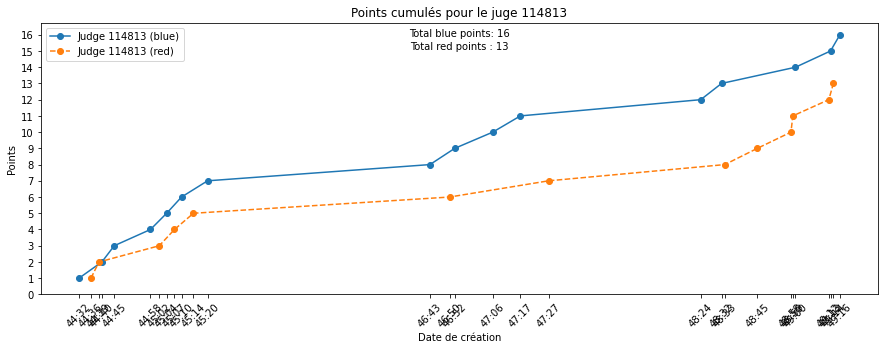

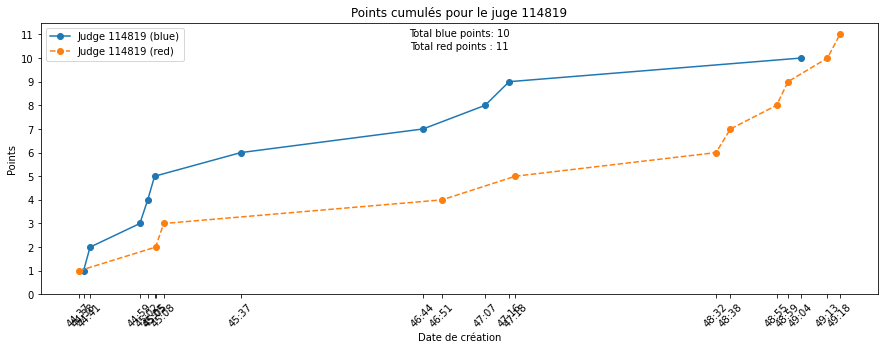

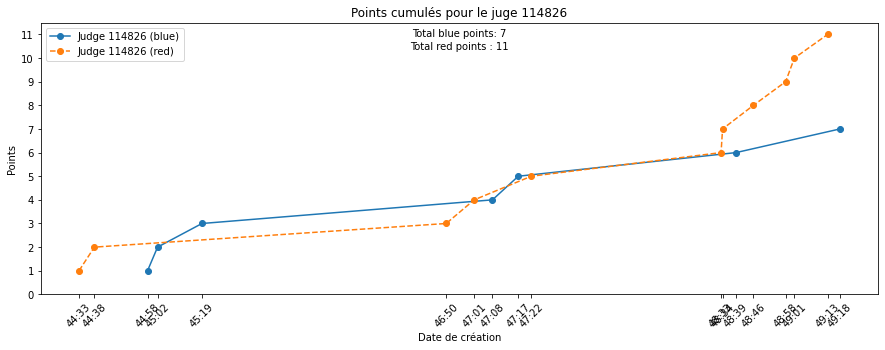

In [23]:
data = data[data['match_id'] == 21096]
data = data.sort_values('date_create_app')

data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]
data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]

grouped_data = data.groupby(['judge_id'])

# Boucle sur les groupes pour créer un graphe par judge_id
for name, group in grouped_data:
    group_blue_points = group[group['date_create_app'].isin(data_blue_points['date_create_app'])]
    group_red_points = group[group['date_create_app'].isin(data_red_points['date_create_app'])]

    cumulative_blue_points = group_blue_points['blue_point'].cumsum()
    cumulative_red_points = group_red_points['red_point'].cumsum()

    # Création d'un graphe pour chaque judge_id
    fig, axs = plt.subplots(figsize=(15, 5))
    
    axs.plot(group_blue_points['date_create_app'], cumulative_blue_points,marker='o', label=f"Judge {name} (blue)")
    axs.plot(group_red_points['date_create_app'], cumulative_red_points, marker='o',label=f"Judge {name} (red)", linestyle='--')

    # Configuration du graphe
    axs.set_xlabel("Date de création")
    axs.set_ylabel("Points")
    axs.legend()

    plt.xticks(rotation=45)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    axs.set_xticks(group['date_create_app'])
    axs.set_xticklabels(group['date_create_app'].dt.strftime('%M:%S'))

    max_points = max(cumulative_blue_points.max(), cumulative_red_points.max()) + 1
    axs.set_yticks(range(0, max_points))

    total_blue_points = group_blue_points['blue_point'].sum()
    axs.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=axs.transAxes, ha="center")

    total_red_points = group_red_points['red_point'].sum()
    axs.text(0.5, 0.9, f"Total red points : {total_red_points}", transform=axs.transAxes, ha="center")

    plt.title(f"Points cumulés pour le juge {name}")
    plt.show()

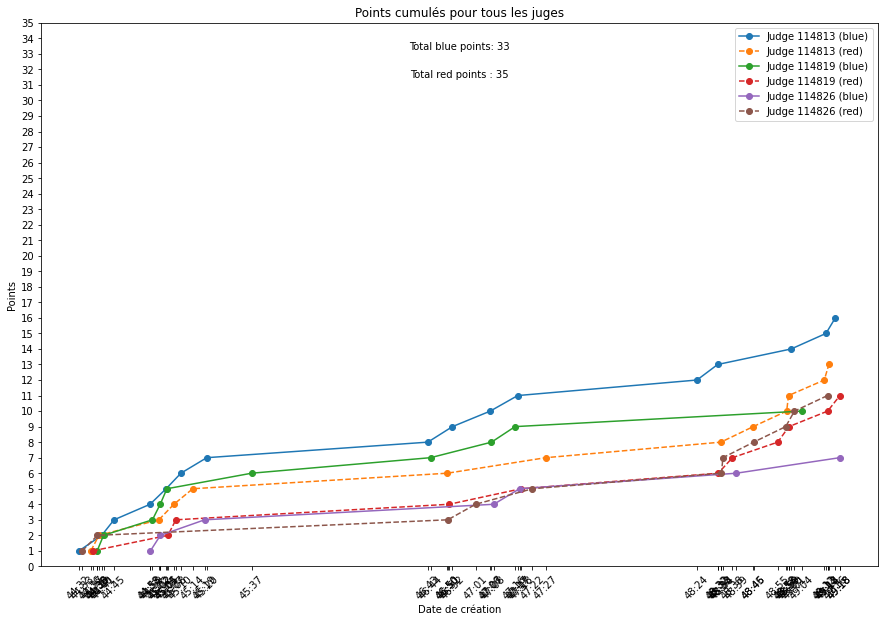

In [52]:
data = data[data['match_id'] == 21096]
data = data.sort_values('date_create_app')

data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]
data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]

grouped_data = data.groupby(['judge_id'])

# Création du graphe
fig, ax = plt.subplots(figsize=(15, 10))

# Boucle sur les groupes pour ajouter les points cumulés pour chaque juge
for name, group in grouped_data:
    group_blue_points = group[group['date_create_app'].isin(data_blue_points['date_create_app'])]
    group_red_points = group[group['date_create_app'].isin(data_red_points['date_create_app'])]

    cumulative_blue_points = group_blue_points['blue_point'].cumsum()
    cumulative_red_points = group_red_points['red_point'].cumsum()

    ax.plot(group_blue_points['date_create_app'], cumulative_blue_points, marker='o', label=f"Judge {name} (blue)")
    ax.plot(group_red_points['date_create_app'], cumulative_red_points, marker='o', label=f"Judge {name} (red)", linestyle='--')

# Configuration du graphe
ax.set_xlabel("Date de création")
ax.set_ylabel("Points")
ax.legend()

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

ax.set_xticks(data['date_create_app'])
ax.set_xticklabels(data['date_create_app'].dt.strftime('%M:%S'))

max_points = max(data['blue_point'].cumsum().max(), data['red_point'].cumsum().max()) + 1
ax.set_yticks(range(0, max_points))

total_blue_points = data_blue_points['blue_point'].sum()
ax.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=ax.transAxes, ha="center")

total_red_points = data_red_points['red_point'].sum()
ax.text(0.5, 0.9, f"Total red points : {total_red_points}", transform=ax.transAxes, ha="center")

plt.title(f"Points cumulés pour tous les juges")
plt.show()


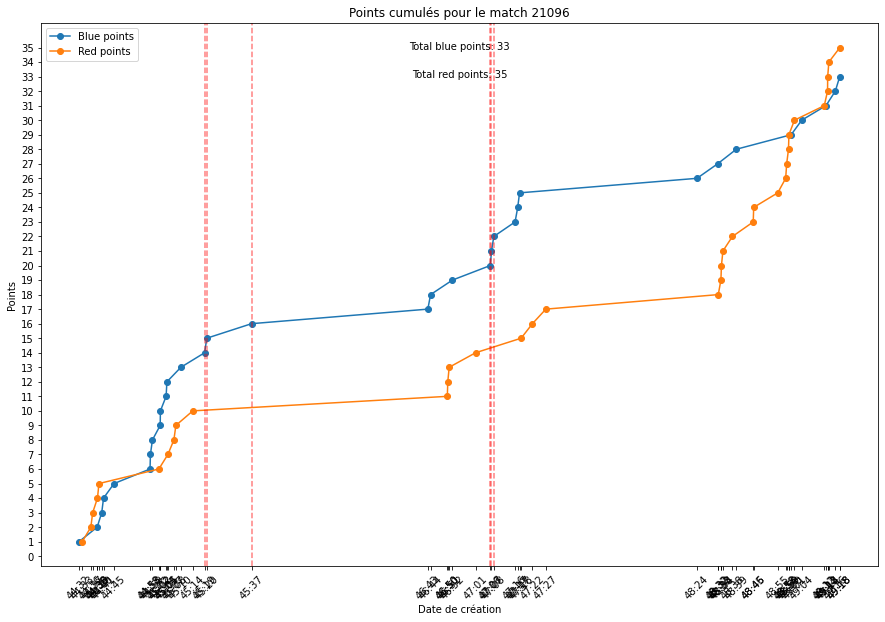

In [25]:
data = data[data['match_id'] == 21096]

data = data.sort_values('date_create_app')

data_red_points = data[data['red_point'] == 1][['date_create_app', 'red_point']]
data_blue_points = data[data['blue_point'] == 1][['date_create_app', 'blue_point']]


cumulative_red_points = data_red_points['red_point'].cumsum()
cumulative_blue_points = data_blue_points['blue_point'].cumsum()

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(data_blue_points['date_create_app'], cumulative_blue_points, marker='o', label='Blue points')
ax.plot(data_red_points['date_create_app'], cumulative_red_points, marker='o', label='Red points')

red_penalty_dates = data[data['red_penalty'] == 1]['date_create_app']
for date in red_penalty_dates:
    ax.axvline(x=date, color='red', linestyle='--', alpha=0.5)

blue_penalty_dates = data[data['blue_penalty'] == 1]['date_create_app']
for date in blue_penalty_dates:
    ax.axvline(x=date, color='blue', linestyle='--', alpha=0.5)

# Configuration du graphe
ax.set_xlabel("Date de création")
ax.set_ylabel("Points")
ax.legend()

plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

ax.set_xticks(data['date_create_app'])
ax.set_xticklabels(data['date_create_app'].dt.strftime('%M:%S'))

max_points = max(cumulative_blue_points.max(), cumulative_red_points.max()) + 1
ax.set_yticks(np.arange(0, max_points, 1))

total_blue_points = cumulative_blue_points.iloc[-1]
ax.text(0.5, 0.95, f"Total blue points: {total_blue_points}", transform=ax.transAxes, ha="center")
total_red_points = cumulative_red_points.iloc[-1]
ax.text(0.5, 0.9, f"Total red points: {total_red_points}", transform=ax.transAxes, ha="center")

plt.title("Points cumulés pour le match 21096")
plt.show()

### DBSCAN 

Round 1
Score ID de la borne inférieure : 401
Score ID de la borne supérieure : 431

Round 2
Score ID de la borne inférieure : 437
Score ID de la borne supérieure : 454

Round 3
Score ID de la borne inférieure : 455
Score ID de la borne supérieure : 483



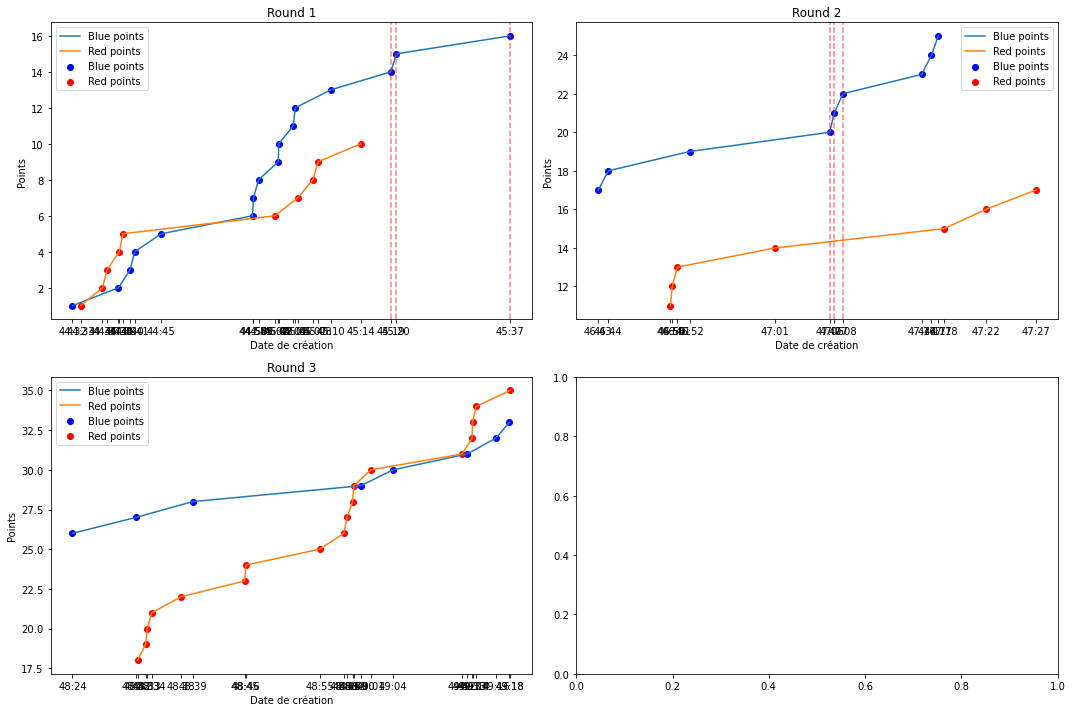

In [37]:
data['timestamp'] = data['date_create_app'].apply(lambda x: x.timestamp())

# Sélection des colonnes à utiliser pour le clustering
features = data[['timestamp']]
score_ids = data['score_id']

# Normalisation des caractéristiques
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Application de DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(normalized_features)

# Récupération des labels de cluster
labels = dbscan.labels_

# Récupération des indices des lignes pour chaque cluster
clusters = {}
for label in set(labels):
    if label != -1:  # Exclure la catégorie des outliers
        cluster_indices = [i for i, l in enumerate(labels) if l == label]
        lower_bound_index = min(cluster_indices)
        upper_bound_index = max(cluster_indices)
        lower_bound_score_id = score_ids.iloc[lower_bound_index]
        upper_bound_score_id = score_ids.iloc[upper_bound_index]
        clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                           'upper_bound_score_id': upper_bound_score_id}

# Affichage des bornes de chaque cluster
for label, bounds in clusters.items():
    print("Round", label+1)
    print("Score ID de la borne inférieure :", bounds['lower_bound_score_id'])
    print("Score ID de la borne supérieure :", bounds['upper_bound_score_id'])
    print()

# Filtrage des données pour les clusters sélectionnés
data_clusters = {}
for label, bounds in clusters.items():
    lower_bound_score_id = bounds['lower_bound_score_id']
    upper_bound_score_id = bounds['upper_bound_score_id']
    cluster_data = data[(data['score_id'] >= lower_bound_score_id) & (data['score_id'] <= upper_bound_score_id)]
    data_clusters[label] = cluster_data

# Paramètres pour la taille des sous-graphiques
num_clusters = len(data_clusters)
num_cols = 2
num_rows = (num_clusters + 1) // num_cols

# Création des sous-graphiques
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Initialisation des valeurs cumulées pour chaque cluster
cumulative_blue_points_prev = 0
cumulative_red_points_prev = 0

# Parcours de chaque cluster et affichage dans un sous-graphique
for i, (label, data_cluster) in enumerate(data_clusters.items()):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # Filtrage des données pour le cluster
    cluster_data = data_cluster[['date_create_app', 'blue_point', 'red_point']]

    data_red_points = cluster_data[cluster_data['red_point'] == 1][['date_create_app', 'red_point']]
    data_blue_points = cluster_data[cluster_data['blue_point'] == 1][['date_create_app', 'blue_point']]

    cumulative_blue_points = cumulative_blue_points_prev + data_blue_points['blue_point'].cumsum()
    cumulative_red_points = cumulative_red_points_prev + data_red_points['red_point'].cumsum()

    cumulative_blue_points_prev = cumulative_blue_points.iloc[-1]
    cumulative_red_points_prev = cumulative_red_points.iloc[-1]

    # Affichage des données du cluster
    ax.plot(data_blue_points['date_create_app'], cumulative_blue_points, label='Blue points')
    ax.plot(data_red_points['date_create_app'], cumulative_red_points, label='Red points')

    # Affichage des points de coordonnées
    ax.scatter(data_blue_points['date_create_app'], cumulative_blue_points, c='blue', label='Blue points')
    ax.scatter(data_red_points['date_create_app'], cumulative_red_points, c='red', label='Red points')

    red_penalty_dates = data_cluster[data_cluster['red_penalty'] == 1]['date_create_app']
    for date in red_penalty_dates:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.5)

    blue_penalty_dates = data_cluster[data_cluster['blue_penalty'] == 1]['date_create_app']
    for date in blue_penalty_dates:
        ax.axvline(x=date, color='blue', linestyle='--', alpha=0.5)

    ax.set_xlabel('Date de création')
    ax.set_ylabel('Points')
    ax.set_title(f'Round {label+1}')
    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))

    ax.set_xticks(cluster_data['date_create_app'])
    ax.set_xticklabels(cluster_data['date_create_app'].dt.strftime('%M:%S'))

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphe
plt.show()

### DTW 
Cette approche permet de capturer la proximité relative entre les lignes consécutives en termes de séquences de dates. Ainsi, chaque ligne est comparée à la fois avec la ligne précédente et la ligne suivante pour estimer sa similarité temporelle avec ses voisines directes.

In [27]:
print(data['date_create_app'].dtype)

datetime64[ns, UTC]


In [28]:
print(data['date_create_app'].isnull().sum())

0


In [29]:

# Fonction pour calculer la distance DTW entre deux séquences de dates
def dtw_distance(sequence1, sequence2):
    sequence1 = np.array(sequence1).reshape(-1, 1)
    sequence2 = np.array(sequence2).reshape(-1, 1)
    distance, _ = fastdtw(sequence1, sequence2, dist=euclidean)
    return distance

# Parcours des rounds pour appliquer DBSCAN à chaque round
for round_label, round_data in data_clusters.items():
    
    # Sélection des colonnes à utiliser pour le clustering
    features = round_data[['timestamp']]

    # Normalisation des caractéristiques
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Application de DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(normalized_features)

    # Récupération des labels de round
    round_labels = dbscan.labels_

    # Récupération des indices des lignes pour chaque round
    round_clusters = {}
    for label in set(round_labels):
        if label != -1:  # Exclure la catégorie des outliers
            cluster_indices = [i for i, l in enumerate(round_labels) if l == label]
            lower_bound_index = min(cluster_indices)
            upper_bound_index = max(cluster_indices)
            lower_bound_score_id = score_ids.iloc[lower_bound_index]
            upper_bound_score_id = score_ids.iloc[upper_bound_index]
            round_clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                                      'upper_bound_score_id': upper_bound_score_id}

    # Parcours des clusters du round actuel
    for cluster_label, cluster_bounds in round_clusters.items():
        cluster_data = round_data[(round_labels == cluster_label) & (round_labels != -1)]

        # Tri du cluster_data par score_id
        sorted_cluster_data = cluster_data.sort_values('score_id')

        # Création d'une colonne pour stocker la distance la plus proche
        sorted_cluster_data['closest_distance'] = np.inf

        # Conversion de la colonne date_create_app en valeurs de temps en millisecondes
        sorted_cluster_data['timestamp_ms'] = sorted_cluster_data['date_create_app'].view('int64') // 10**6

        # Parcours des lignes pour calculer la distance la plus proche
        for i in range(1, len(sorted_cluster_data)):
            current_row = sorted_cluster_data.iloc[i]
            previous_row = sorted_cluster_data.iloc[i-1]
            current_sequence = current_row['timestamp_ms']
            previous_sequence = previous_row['timestamp_ms']
            distance = dtw_distance(current_sequence, previous_sequence)
            sorted_cluster_data.at[current_row.name, 'closest_distance'] = distance

        # Suppression des valeurs "inf"
        filtered_cluster_data_no_inf = sorted_cluster_data[sorted_cluster_data['closest_distance'] != np.inf]

        # Calcul des statistiques des distances
        mean_distance = filtered_cluster_data_no_inf['closest_distance'].mean()
        std_distance = filtered_cluster_data_no_inf['closest_distance'].std()

        # Affichage des statistiques, y compris la déviation standard
        print("Round", round_label + 1)
        print("Echanges", cluster_label + 1)
        print("Moyenne de closest_distance :", mean_distance)
        print("Écart-type de closest_distance :", std_distance)
        print()

        # Affichage des colonnes spécifiées pour les données du cluster
        cols_to_display = ['score_id', 'date_create_app', 'closest_distance', 'judge_id']
        print("Round", round_label + 1)
        print("Echanges", cluster_label + 1)
        print(sorted_cluster_data[cols_to_display])
        print()

Round 1
Echanges 1
Moyenne de closest_distance : 1465.888888888889
Écart-type de closest_distance : 1300.1304208082784

Round 1
Echanges 1
     score_id                  date_create_app  closest_distance  judge_id
400       401 2021-06-26 11:44:32.023000+00:00               inf    114813
401       402 2021-06-26 11:44:33.222000+00:00            1199.0    114826
402       403 2021-06-26 11:44:36.483000+00:00            3261.0    114813
403       404 2021-06-26 11:44:37.176000+00:00             693.0    114819
404       405 2021-06-26 11:44:38.860000+00:00            1684.0    114819
405       406 2021-06-26 11:44:38.985000+00:00             125.0    114826
406       407 2021-06-26 11:44:39.533000+00:00             548.0    114813
407       408 2021-06-26 11:44:40.583000+00:00            1050.0    114813
409       410 2021-06-26 11:44:41.268000+00:00             685.0    114819
411       412 2021-06-26 11:44:45.216000+00:00            3948.0    114813

Round 1
Echanges 2
Moyenne de close

In [50]:
# Fonction pour calculer la distance DTW entre deux séquences de dates
def dtw_distance(sequence1, sequence2):
    sequence1 = np.array(sequence1).reshape(-1, 1)
    sequence2 = np.array(sequence2).reshape(-1, 1)
    distance, _ = fastdtw(sequence1, sequence2, dist=euclidean)
    return distance

# Parcours des rounds pour appliquer DBSCAN à chaque round
for round_label, round_data in data_clusters.items():
    
    # Sélection des colonnes à utiliser pour le clustering
    features = round_data[['timestamp']]

    # Normalisation des caractéristiques
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Application de DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan.fit(normalized_features)

    # Récupération des labels de round
    round_labels = dbscan.labels_

    # Récupération des indices des lignes pour chaque round
    round_clusters = {}
    for label in set(round_labels):
        if label != -1:  # Exclure la catégorie des outliers
            cluster_indices = [i for i, l in enumerate(round_labels) if l == label]
            lower_bound_index = min(cluster_indices)
            upper_bound_index = max(cluster_indices)
            lower_bound_score_id = score_ids.iloc[lower_bound_index]
            upper_bound_score_id = score_ids.iloc[upper_bound_index]
            round_clusters[label] = {'lower_bound_score_id': lower_bound_score_id,
                                      'upper_bound_score_id': upper_bound_score_id}

    # Parcours des clusters du round actuel
    for cluster_label, cluster_bounds in round_clusters.items():
        cluster_data = round_data[(round_labels == cluster_label) & (round_labels != -1)]

        # Tri du cluster_data par score_id
        sorted_cluster_data = cluster_data.sort_values('score_id')

        # Création d'une colonne pour stocker la distance la plus proche
        sorted_cluster_data['closest_distance'] = np.inf

        # Conversion de la colonne date_create_app en valeurs de temps en millisecondes
        sorted_cluster_data['timestamp_ms'] = sorted_cluster_data['date_create_app'].view('int64') // 10**6

        # Parcours des lignes pour calculer la distance la plus proche
        for i in range(1, len(sorted_cluster_data)):
            current_row = sorted_cluster_data.iloc[i]
            previous_row = sorted_cluster_data.iloc[i-1]
            current_sequence = current_row['timestamp_ms']
            previous_sequence = previous_row['timestamp_ms']
            distance = dtw_distance(current_sequence, previous_sequence)
            sorted_cluster_data.at[current_row.name, 'closest_distance'] = distance

        # Suppression des valeurs "inf"
        filtered_cluster_data_no_inf = sorted_cluster_data[sorted_cluster_data['closest_distance'] != np.inf]

        # Calcul des statistiques des distances
        mean_distance = filtered_cluster_data_no_inf['closest_distance'].mean()
        std_distance = filtered_cluster_data_no_inf['closest_distance'].std()

        # Affichage des statistiques, y compris la déviation standard
        print("Round", round_label + 1)
        print("Echanges", cluster_label + 1)
        print("Moyenne de closest_distance :", mean_distance)
        print("Écart-type de closest_distance :", std_distance)
        print()

        # Détection des petits échanges
        small_exchanges = []
        current_small_exchange = []
        for i, row in sorted_cluster_data.iterrows():
            if row['closest_distance'] > std_distance:
                if current_small_exchange:
                    small_exchanges.append(current_small_exchange)
                current_small_exchange = [row]
            else:
                current_small_exchange.append(row)
        if current_small_exchange:
            small_exchanges.append(current_small_exchange)

        # Affichage des colonnes spécifiées pour les données du cluster
        cols_to_display = ['score_id', 'date_create_app', 'closest_distance', 'judge_id']
        for i, small_exchange in enumerate(small_exchanges):
            print("Petit échange", i + 1)
            print(pd.DataFrame(small_exchange, columns=cols_to_display))
            print()


Round 1
Echanges 1
Moyenne de closest_distance : 1465.888888888889
Écart-type de closest_distance : 1300.1304208082784

Petit échange 1
     score_id                  date_create_app  closest_distance  judge_id
400       401 2021-06-26 11:44:32.023000+00:00               inf    114813
401       402 2021-06-26 11:44:33.222000+00:00            1199.0    114826

Petit échange 2
     score_id                  date_create_app  closest_distance  judge_id
402       403 2021-06-26 11:44:36.483000+00:00            3261.0    114813
403       404 2021-06-26 11:44:37.176000+00:00             693.0    114819

Petit échange 3
     score_id                  date_create_app  closest_distance  judge_id
404       405 2021-06-26 11:44:38.860000+00:00            1684.0    114819
405       406 2021-06-26 11:44:38.985000+00:00             125.0    114826
406       407 2021-06-26 11:44:39.533000+00:00             548.0    114813
407       408 2021-06-26 11:44:40.583000+00:00            1050.0    114813
409  